In [1]:
import os
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap # new, also need basemap-data-hires

DATABASE_PATH = '../data/sdwis/WATER_SYSTEM_clean.zip' # my local cleaned version of the zipped data on slack

# Allow us to display all the columns in a dataframe
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv(DATABASE_PATH, compression='zip', header=0, sep='|', quotechar='"', low_memory=False, index_col=False)
df.shape

(421244, 44)

*Add population served categories*

In [3]:
df.POPULATION_SERVED_COUNT.max()

10000000

In [4]:
# test = pd.DataFrame({'days': [0,500,10000000]})
# test['range'] = pd.cut(test.days, [0,500,10000001], include_lowest=True, right=False)
# test

In [5]:
df['POP_SERV_CAT'] = pd.cut(df['POPULATION_SERVED_COUNT'], [0,500,10000001], 
                            include_lowest=True, right=False,
                            labels=["small", "large"])

In [6]:
df.head(5)

ADDRESS_LINE1                   ADDRESS_LINE2  \
0     Tribal Office    Indiantown Rd, - PO BOX 3060   
1               NaN                             NaN   
2  5 Crow Hill Road                             NaN   
3      P.O. Box 479                             NaN   
4           BOX 231  SOUTH COUNTY TRAIL,RT.112,RT.2   

                      ADMIN_NAME ALT_PHONE_NUMBER CDS_ID     CITY_NAME  \
0                  Rodney Butler              NaN    NaN  MASHANTUCKET   
1                            NaN              NaN    NaN           NaN   
2                    Kevin Brown              NaN    NaN    Uncasville   
3                 Willard Marden              NaN    NaN      Chilmark   
4  NARRAGANSETT INDIAN LONGHOUSE              NaN    NaN   CHARLESTOWN   

  COUNTRY_CODE  DBPR_SCHEDULE_CAT_CODE          EMAIL_ADDR EPA_REGION  \
0           US                     NaN                 NaN         01   
1          NaN                     NaN                 NaN         01   
2           US                     NaN                 NaN         01   
3           US                     NaN  awtha1@comcast.net         01   
4           US                     NaN                 NaN         01   

  FAX_NUMBER GW_SW_CODE IS_GRANT_ELIGIBLE_IND IS_SCHOOL_OR_DAYCARE_IND  \
0        NaN         SW                     Y                        N   
1        NaN         GW                     N                        N   
2        NaN         SW                     Y                        N   
3        NaN         GW                     Y                        N   
4        NaN         GW                     N                        N   

  IS_WHOLESALER_IND LT2_SCHEDULE_CAT_CODE  \
0                 Y                   NaN   
1                 N                   NaN   
2                 N                   NaN   
3                 N                   NaN   
4                 N                   NaN   

                                      ORG_NAME OUTSTANDING_PERFORMER  \
0         Mashantucket Pequot Tribal Utilities                   NaN   
1                                          NaN                   NaN   
2                                Mohegan Tribe                   NaN   
3  Aquinnah Wampanoag Tribal Housing Authority                   NaN   
4                                          NaN                   NaN   

  OUTSTANDING_PERFORM_BEGIN_DATE OWNER_TYPE_CODE PHONE_EXT_NUMBER  \
0                            NaN               N              NaN   
1                            NaN               N              NaN   
2                            NaN               N              NaN   
3                            NaN               N              NaN   
4                            NaN               N              NaN   

   PHONE_NUMBER  POPULATION_SERVED_COUNT  POP_CAT_11_CODE POP_CAT_2_CODE  \
0    8603966740                    39552                6              2   
1           NaN                    41185                6              2   
2           NaN                    37860                6              2   
3    5086452711                       84                1              1   
4  401-364-1117                       30                1              1   

  POP_CAT_3_CODE POP_CAT_4_CODE POP_CAT_5_CODE PRIMACY_AGENCY_CODE  \
0              2              2              4                  01   
1              2              2              4                  01   
2              2              2              4                  01   
3              1              1              1                  01   
4              1              1              1                  01   

  PRIMACY_TYPE PRIMARY_SOURCE_CODE      PWSID PWS_ACTIVITY_CODE  \
0       Tribal                  GU  010106001                 A   
1       Tribal                  GW  010109001                 I   
2       Tribal                 SWP  010109005                 A   
3       Tribal                  GW  010307001                 A   
4       Tribal

### I. Data cleaning, filtering, aggregating

*ZIP_CODE needs cleaning*

In [7]:
df = df.dropna(subset=['ZIP_CODE']) # Drop rows with zipcode NA
df.shape

(402552, 45)

*Get the first 5 digits*

In [8]:
df = df.assign(ZIP_CODE_5 = df.ZIP_CODE.str[:5])

*Filter down to active, cws*

In [9]:
df_ACWS = df[(df.PWS_ACTIVITY_CODE == 'A') & (df.PWS_TYPE_CODE == 'CWS')]
df_ACWS.shape

(49753, 46)

In [10]:
df_ACWS_distinct = df_ACWS.loc[:, ['PWSID', 'STATE_CODE', 'POPULATION_SERVED_COUNT', 
                                   'OWNER_TYPE_CODE', 'ZIP_CODE_5']].drop_duplicates()
len(df_ACWS_distinct.index)

49753

*Including only lower 48 + DC for below*

In [11]:
df_ACWS.STATE_CODE.unique()

array(['CT', 'MA', 'NY', 'AL', 'FL', 'MS', 'NC', 'MI', 'MN', 'WI', 'OK',
       'TX', 'LA', 'NM', 'KS', 'IA', 'NE', 'CO', 'MT', 'ND', 'SD', 'UT',
       'WY', 'AZ', 'CA', 'NV', 'AK', 'ID', 'OR', 'WA', 'TN', 'AS', 'AR',
       'MO', 'VA', 'NJ', 'HI', 'IL', 'RI', 'DC', 'MD', 'DE', 'GA', 'SC',
       'PA', 'OH', 'KY', 'GU', 'IN', 'WV', 'NH', 'ME', 'VT', 'ON', 'BC',
       'MP', 'PR', 'VI', 'PQ'], dtype=object)

In [12]:
exclude = ['AK', 'HI', 'AS', 'GU', 'ON', 'BC', 'MP', 'PR', 'VI', 'PQ']

df_ACWS49 = df_ACWS[~df_ACWS.STATE_CODE.isin(exclude)]
len(df_ACWS49.index)

48684

### II. Mapping

1. join with spatial info (zip code level)
2. mapping using basemap: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

**Notes:** something to keep in mind, zip codes aren't really well defined areas: https://gis.stackexchange.com/questions/5114/obtaining-up-to-date-list-of-us-zip-codes-with-latitude-and-longitude-geocodes

trying this data (zip code tablulation areas from US census):
https://www.census.gov/geo/maps-data/data/gazetteer2016.html

In [13]:
ZIPCOORDS_PATH = '../data/spatial/2016_Gaz_zcta_national.zip'

ZipCoords = pd.read_csv(ZIPCOORDS_PATH, compression='zip', header=0, sep='\t', 
                        dtype={0:'str'}, quotechar='"', low_memory=False, index_col=False)
ZipCoords.shape

(33144, 7)

In [14]:
print(ZipCoords.columns) # Bad last column name

Index(['GEOID', 'ALAND', 'AWATER', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT',
       'INTPTLONG                                                                                                                                  '],
      dtype='object')


In [15]:
col_name =ZipCoords.columns[6]
ZipCoords=ZipCoords.rename(columns = {col_name:'INTPTLONG'})

In [16]:
ZipCoords.head(5)

GEOID      ALAND   AWATER  ALAND_SQMI  AWATER_SQMI   INTPTLAT  INTPTLONG
0  00601  166659884   799293      64.348        0.309  18.180555 -66.749961
1  00602   79287203  4448761      30.613        1.718  18.361945 -67.175597
2  00603   81884707   183895      31.616        0.071  18.455183 -67.119887
3  00606  109579998    12487      42.309        0.005  18.158345 -66.932911
4  00610   93020979  4171994      35.916        1.611  18.295366 -67.125135

In [17]:
## Maybe another way:
# pd.cross_tab()

## This seems workable:
# http://pbpython.com/pandas-pivot-table-explained.html

# some zip codes go across state lines, so keeping it reduced
df_ACWS49_p1 = pd.pivot_table(df_ACWS49, index=["ZIP_CODE_5"], columns=["OWNER_TYPE_CODE"], 
                               aggfunc={"OWNER_TYPE_CODE":len}, fill_value=0)
len(df_ACWS49_p1.index)

20788

In [18]:
df_ACWS49_p1.head()

OWNER_TYPE_CODE               
OWNER_TYPE_CODE               F  L  M  N  P  S
ZIP_CODE_5                                    
01001                         0  1  0  0  1  0
01002                         0  1  0  0  0  0
01005                         0  1  0  0  1  0
01007                         0  1  0  0  3  0
01008                         0  1  0  0  0  0

In [19]:
df_ACWS49_p1f = pd.DataFrame(df_ACWS49_p1.to_records())
df_ACWS49_p1f.columns = [hdr.replace("('OWNER_TYPE_CODE', ", "OTC.").replace(")", "").replace("'", "") \
                     for hdr in df_ACWS49_p1f.columns]

df_ACWS49_p1f.head()

ZIP_CODE_5  OTC.F  OTC.L  OTC.M  OTC.N  OTC.P  OTC.S
0      01001      0      1      0      0      1      0
1      01002      0      1      0      0      0      0
2      01005      0      1      0      0      1      0
3      01007      0      1      0      0      3      0
4      01008      0      1      0      0      0      0

In [20]:
df_ACWS49_xy = pd.merge(df_ACWS49_p1f, ZipCoords, left_on='ZIP_CODE_5', right_on='GEOID', how='inner', validate="m:1")

print('unmatched =', len(df_ACWS49_p1f.index) - len(df_ACWS49_xy.index))

unmatched = 1372


In [21]:
display(len(df_ACWS49_xy.index))
display(df_ACWS49_xy.ZIP_CODE_5.nunique())
df_ACWS49_xy.head()

19416

19416

ZIP_CODE_5  OTC.F  OTC.L  OTC.M  OTC.N  OTC.P  OTC.S  GEOID      ALAND  \
0      01001      0      1      0      0      1      0  01001   29731610   
1      01002      0      1      0      0      0      0  01002  142617829   
2      01005      0      1      0      0      1      0  01005  114637908   
3      01007      0      1      0      0      3      0  01007  136236049   
4      01008      0      1      0      0      0      0  01008  139346414   

    AWATER  ALAND_SQMI  AWATER_SQMI   INTPTLAT  INTPTLONG  
0  2118827      11.479        0.818  42.062368 -72.625754  
1  4276681      55.065        1.651  42.364060 -72.458741  
2   666424      44.262        0.257  42.418848 -72.106598  
3  6944239      52.601        2.681  42.279010 -72.400468  
4  5108939      53.802        1.973  42.190191 -72.954263

*Looking into unmatched, but proceeding for now*

## Overall map

In [22]:
# Extract the data for plotting
lat = df_ACWS49_xy['INTPTLAT'].values
lon = df_ACWS49_xy['INTPTLONG'].values

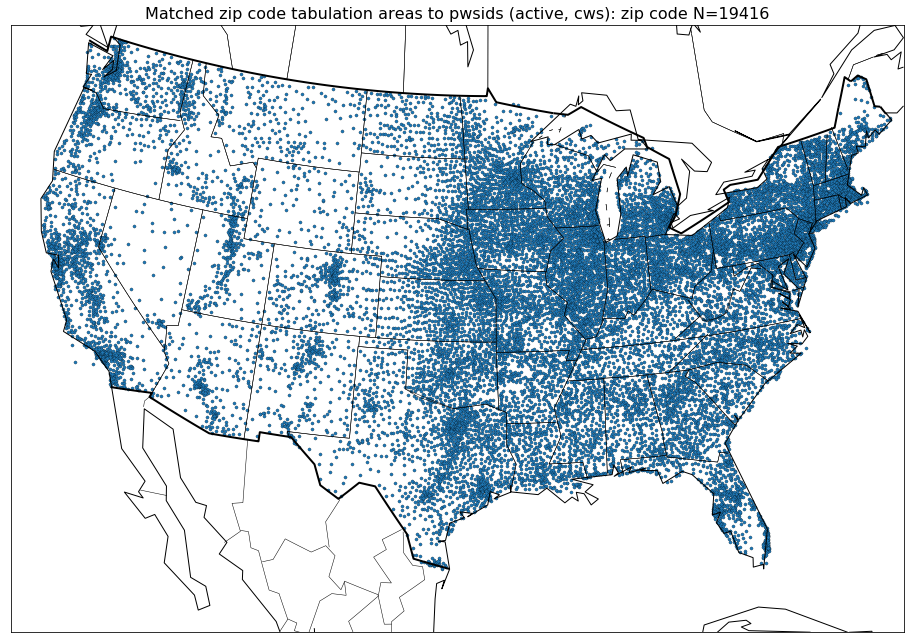

In [23]:
# see also: https://dataverse.tech/2018/04/20/basemap/

plt.figure(figsize=(16, 16))
# Lambert Conformal map of lower 49 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
# m.drawrivers(color='blue')
# m.fillcontinents(color='g', lake_color='blue', alpha=0.5)
m.drawstates()
# m.bluemarble()

m.scatter(lon, lat, latlon=True, marker='o', 
          edgecolor='black', s=10, lw = 0.2) #, alpha = 0.5

t = len(df_ACWS49_xy.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws): zip code N=%i' %t, fontsize = 16)
plt.show()

1. Now have these, would like to link to violations to map contaminants. First though, by OWNER_TYPE_CODE

*OWNER_TYPE_CODE Description: Code that dentifies the ownership category of the water system consisting of: F (Federal Government), L (Local Government), M (Public/Private), N (Native American), P (Private), or S (State Government).*

### Federal

In [24]:
df_ACWS49_xy_F0 = df_ACWS49_xy[df_ACWS49_xy['OTC.F'] == 0]
df_ACWS49_xy_F1 = df_ACWS49_xy[df_ACWS49_xy['OTC.F'] > 0]

# Extract the data for plotting
lat_F0 = df_ACWS49_xy_F0['INTPTLAT'].values
lon_F0 = df_ACWS49_xy_F0['INTPTLONG'].values

lat_F1 = df_ACWS49_xy_F1['INTPTLAT'].values
lon_F1 = df_ACWS49_xy_F1['INTPTLONG'].values


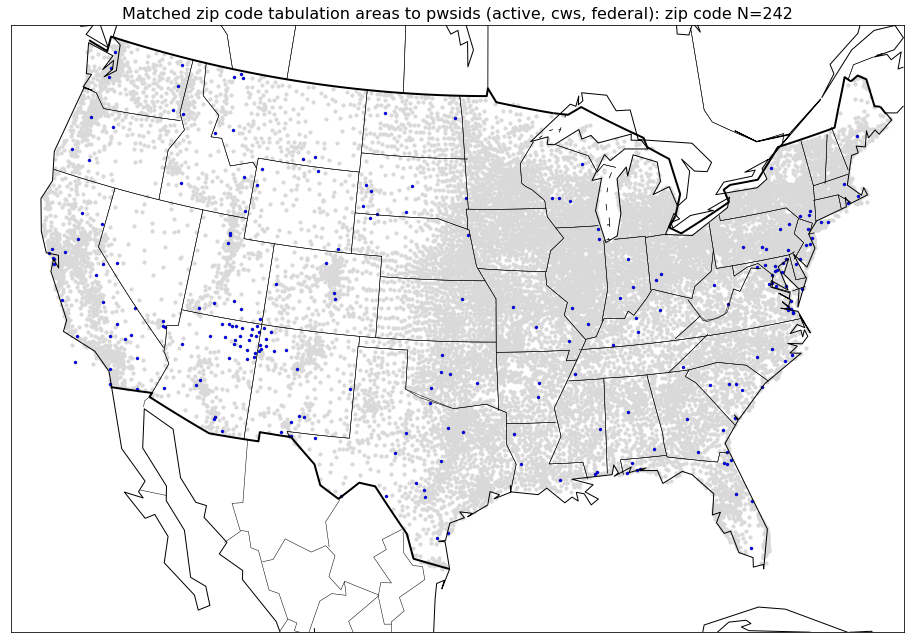

In [25]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_F0, lat_F0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_F1, lat_F1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy_F1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, federal): zip code N=%i' %t, fontsize = 16)
plt.show()

### Local

In [26]:
df_ACWS49_xy_L0 = df_ACWS49_xy[df_ACWS49_xy['OTC.L'] == 0]
df_ACWS49_xy_L1 = df_ACWS49_xy[df_ACWS49_xy['OTC.L'] > 0]

# Extract the data for plotting
lat_L0 = df_ACWS49_xy_L0['INTPTLAT'].values
lon_L0 = df_ACWS49_xy_L0['INTPTLONG'].values

lat_L1 = df_ACWS49_xy_L1['INTPTLAT'].values
lon_L1 = df_ACWS49_xy_L1['INTPTLONG'].values


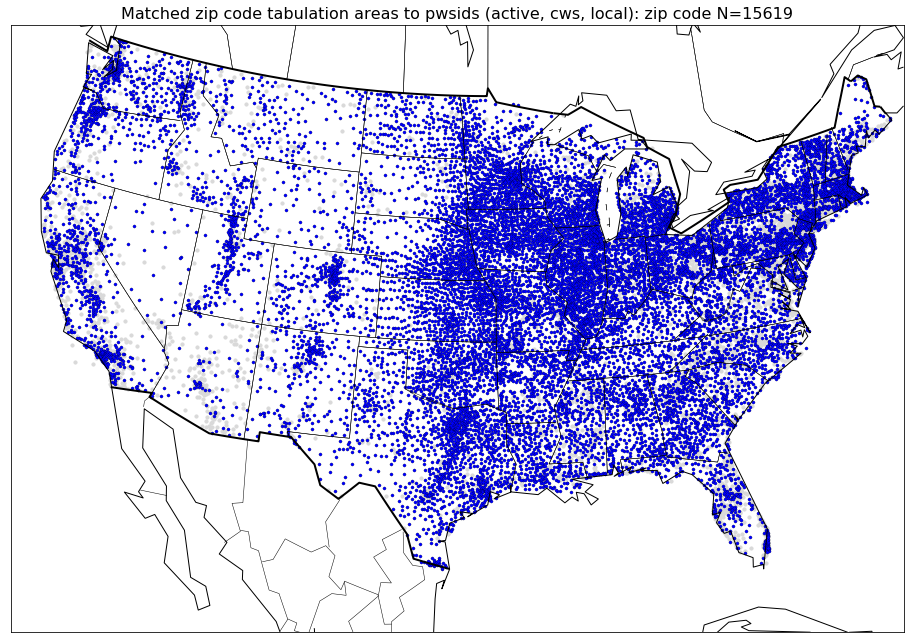

In [27]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_L0, lat_L0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_L1, lat_L1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy_L1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, local): zip code N=%i' %t, fontsize = 16)
plt.show()

### Public/Private

In [28]:
df_ACWS49_xy_M0 = df_ACWS49_xy[df_ACWS49_xy['OTC.M'] == 0]
df_ACWS49_xy_M1 = df_ACWS49_xy[df_ACWS49_xy['OTC.M'] > 0]

# Extract the data for plotting
lat_M0 = df_ACWS49_xy_M0['INTPTLAT'].values
lon_M0 = df_ACWS49_xy_M0['INTPTLONG'].values

lat_M1 = df_ACWS49_xy_M1['INTPTLAT'].values
lon_M1 = df_ACWS49_xy_M1['INTPTLONG'].values


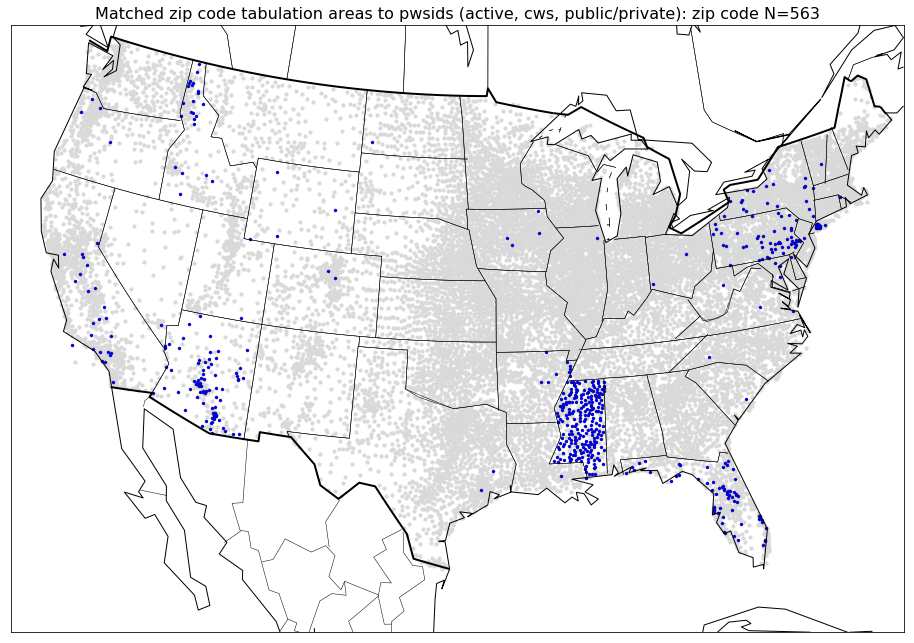

In [29]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_M0, lat_M0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_M1, lat_M1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy_M1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, public/private): zip code N=%i' %t, fontsize = 16)
plt.show()

### Native American

In [30]:
df_ACWS49_xy_N0 = df_ACWS49_xy[df_ACWS49_xy['OTC.N'] == 0]
df_ACWS49_xy_N1 = df_ACWS49_xy[df_ACWS49_xy['OTC.N'] > 0]

# Extract the data for plotting
lat_N0 = df_ACWS49_xy_N0['INTPTLAT'].values
lon_N0 = df_ACWS49_xy_N0['INTPTLONG'].values

lat_N1 = df_ACWS49_xy_N1['INTPTLAT'].values
lon_N1 = df_ACWS49_xy_N1['INTPTLONG'].values


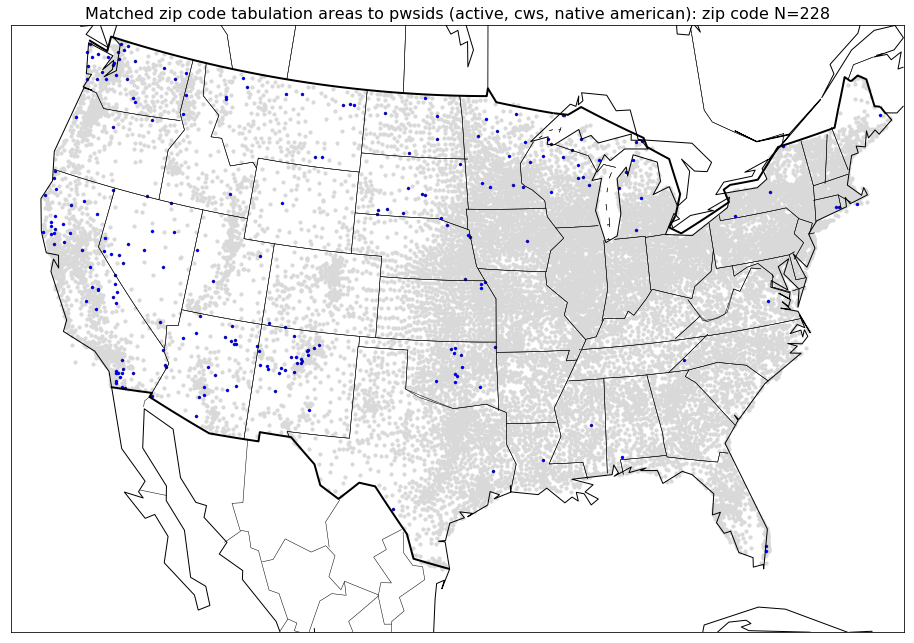

In [31]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_N0, lat_N0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_N1, lat_N1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy_N1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, native american): zip code N=%i' %t, fontsize = 16)
plt.show()

### Private

In [32]:
df_ACWS49_xy_P0 = df_ACWS49_xy[df_ACWS49_xy['OTC.P'] == 0]
df_ACWS49_xy_P1 = df_ACWS49_xy[df_ACWS49_xy['OTC.P'] > 0]

# Extract the data for plotting
lat_P0 = df_ACWS49_xy_P0['INTPTLAT'].values
lon_P0 = df_ACWS49_xy_P0['INTPTLONG'].values

lat_P1 = df_ACWS49_xy_P1['INTPTLAT'].values
lon_P1 = df_ACWS49_xy_P1['INTPTLONG'].values


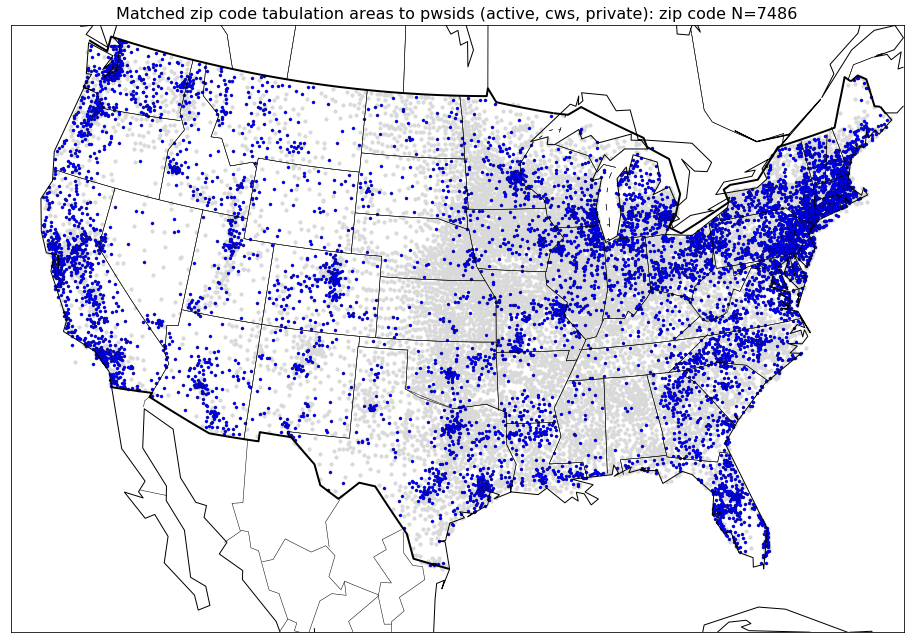

In [33]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_P0, lat_P0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_P1, lat_P1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy_P1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, private): zip code N=%i' %t, fontsize = 16)
plt.show()

### State

In [34]:
df_ACWS49_xy_S0 = df_ACWS49_xy[df_ACWS49_xy['OTC.S'] == 0]
df_ACWS49_xy_S1 = df_ACWS49_xy[df_ACWS49_xy['OTC.S'] > 0]

# Extract the data for plotting
lat_S0 = df_ACWS49_xy_S0['INTPTLAT'].values
lon_S0 = df_ACWS49_xy_S0['INTPTLONG'].values

lat_S1 = df_ACWS49_xy_S1['INTPTLAT'].values
lon_S1 = df_ACWS49_xy_S1['INTPTLONG'].values


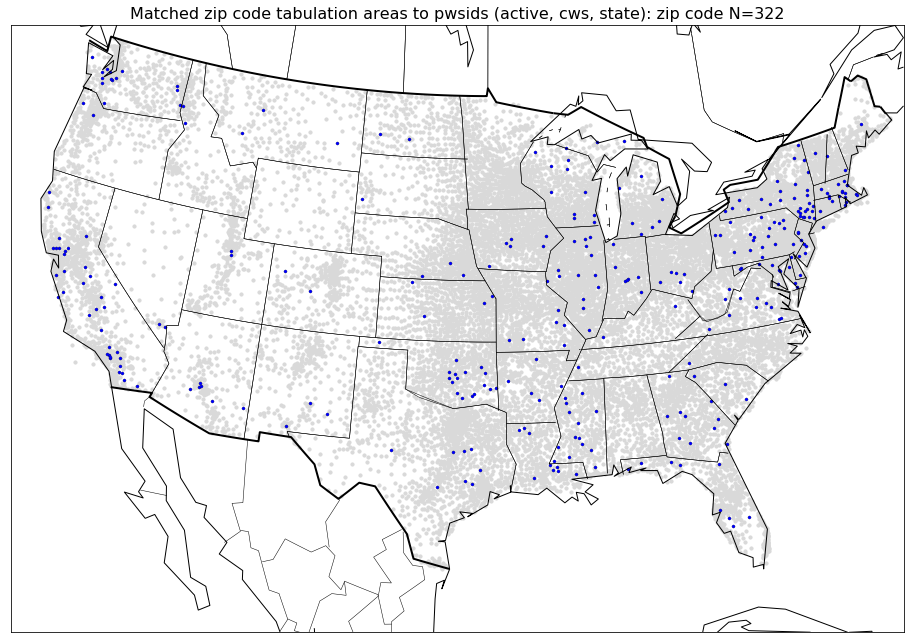

In [35]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_S0, lat_S0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_S1, lat_S1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy_S1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, state): zip code N=%i' %t, fontsize = 16)
plt.show()

### By population served cutoff

In [36]:
# some zip codes go across state lines, so keeping it reduced
df_ACWS49_p2 = pd.pivot_table(df_ACWS49, index=["ZIP_CODE_5"], columns=["POP_SERV_CAT"], 
                               aggfunc={"POP_SERV_CAT":len}, fill_value=0)
len(df_ACWS49_p2.index)

20788

In [37]:
df_ACWS49_p2.head()

POP_SERV_CAT      
POP_SERV_CAT        large small
ZIP_CODE_5                     
01001                   1     1
01002                   1     0
01005                   1     1
01007                   2     2
01008                   1     0

In [38]:
df_ACWS49_p2f = pd.DataFrame(df_ACWS49_p2.to_records())
df_ACWS49_p2f.columns = [hdr.replace("('POP_SERV_CAT', ", "").replace(")", "").replace("'", "") \
                     for hdr in df_ACWS49_p2f.columns]

df_ACWS49_p2f.head()

ZIP_CODE_5  large  small
0      01001      1      1
1      01002      1      0
2      01005      1      1
3      01007      2      2
4      01008      1      0

In [39]:
df_ACWS49_xy2 = pd.merge(df_ACWS49_p2f, ZipCoords, left_on='ZIP_CODE_5', right_on='GEOID', how='inner', validate="m:1")

print('unmatched =', len(df_ACWS49_p2f.index) - len(df_ACWS49_xy2.index))

unmatched = 1372


### At least one large (>=500)

In [40]:
df_ACWS49_xy2_Lg0 = df_ACWS49_xy2[df_ACWS49_xy2['large'] == 0]
df_ACWS49_xy2_Lg1 = df_ACWS49_xy2[df_ACWS49_xy2['large'] > 0]

# Extract the data for plotting
lat_Lg0 = df_ACWS49_xy2_Lg0['INTPTLAT'].values
lon_Lg0 = df_ACWS49_xy2_Lg0['INTPTLONG'].values

lat_Lg1 = df_ACWS49_xy2_Lg1['INTPTLAT'].values
lon_Lg1 = df_ACWS49_xy2_Lg1['INTPTLONG'].values


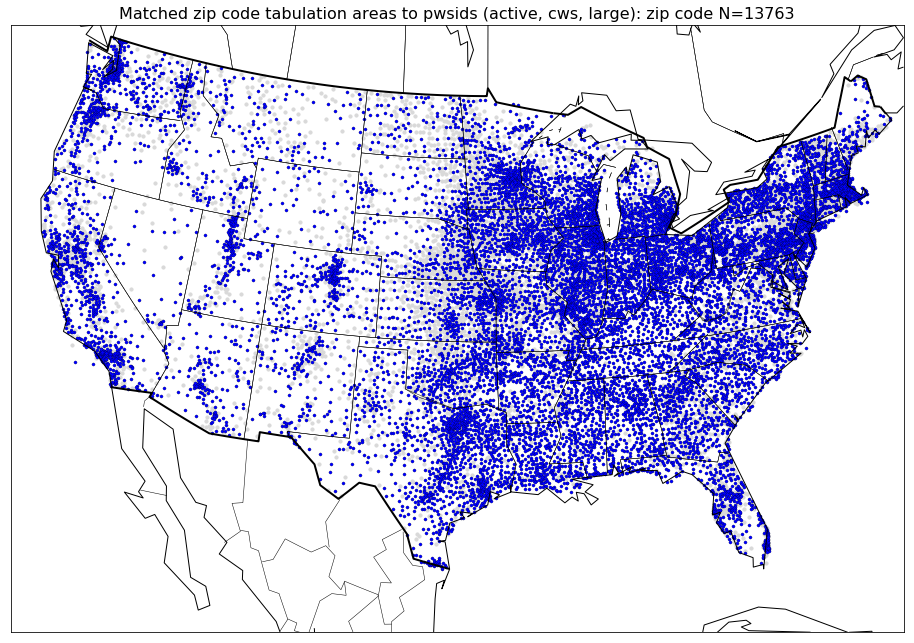

In [41]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_Lg0, lat_Lg0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_Lg1, lat_Lg1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy2_Lg1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, large): zip code N=%i' %t, fontsize = 16)
plt.show()

### At least one small (<500)

In [42]:
df_ACWS49_xy2_Sm0 = df_ACWS49_xy2[df_ACWS49_xy2['small'] == 0]
df_ACWS49_xy2_Sm1 = df_ACWS49_xy2[df_ACWS49_xy2['small'] > 0]

# Extract the data for plotting
lat_Sm0 = df_ACWS49_xy2_Sm0['INTPTLAT'].values
lon_Sm0 = df_ACWS49_xy2_Sm0['INTPTLONG'].values

lat_Sm1 = df_ACWS49_xy2_Sm1['INTPTLAT'].values
lon_Sm1 = df_ACWS49_xy2_Sm1['INTPTLONG'].values


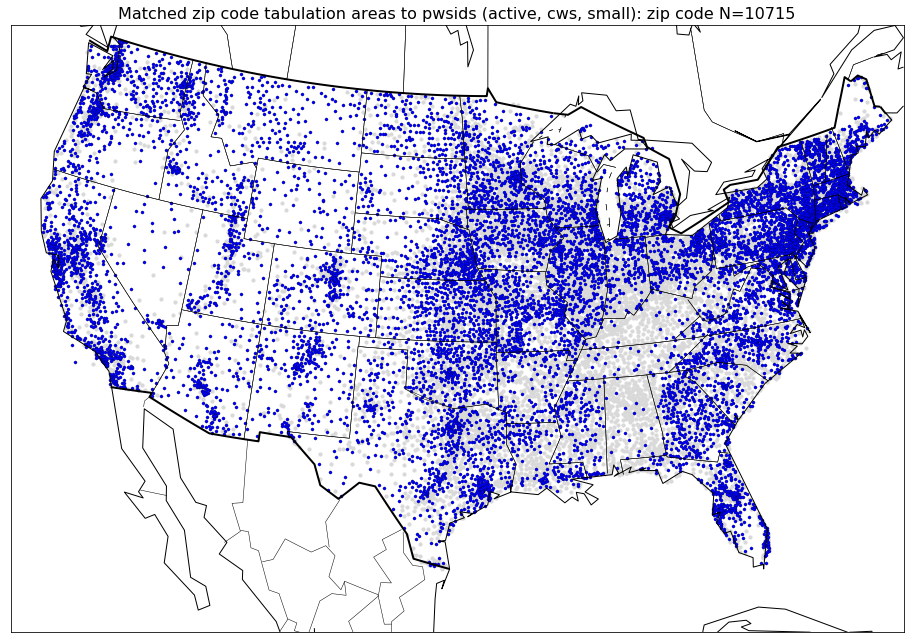

In [43]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_Sm0, lat_Sm0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_Sm1, lat_Sm1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy2_Sm1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, small): zip code N=%i' %t, fontsize = 16)
plt.show()

### At least one small (<500) and no large (>=500)

In [44]:
df_ACWS49_xy2_Smx0 = df_ACWS49_xy2[(df_ACWS49_xy2['small'] == 0) & (df_ACWS49_xy2['large'] > 0)]
df_ACWS49_xy2_Smx1 = df_ACWS49_xy2[(df_ACWS49_xy2['small'] > 0) & (df_ACWS49_xy2['large'] == 0)]

# Extract the data for plotting
lat_Smx0 = df_ACWS49_xy2_Smx0['INTPTLAT'].values
lon_Smx0 = df_ACWS49_xy2_Smx0['INTPTLONG'].values

lat_Smx1 = df_ACWS49_xy2_Smx1['INTPTLAT'].values
lon_Smx1 = df_ACWS49_xy2_Smx1['INTPTLONG'].values


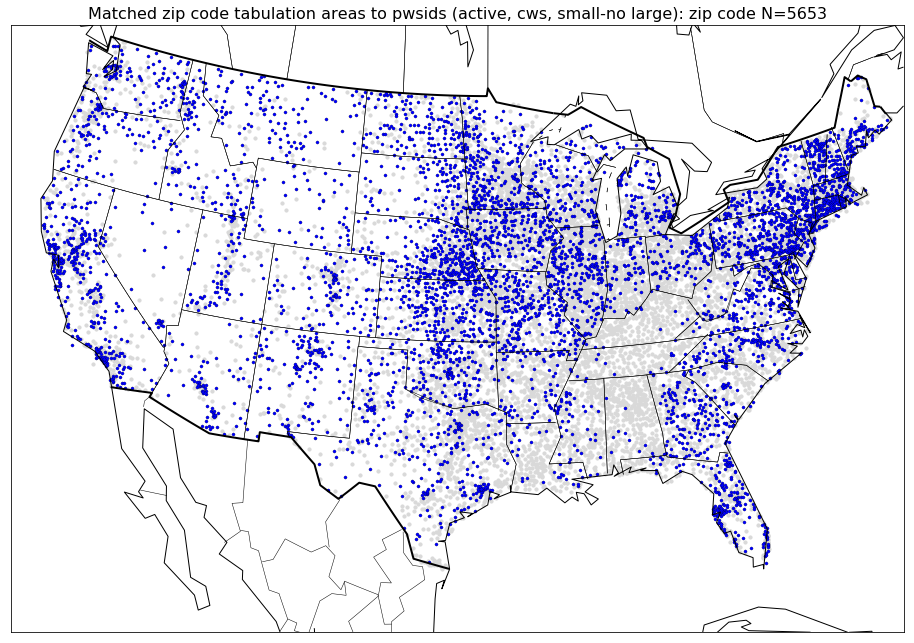

In [45]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_Smx0, lat_Smx0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_Smx1, lat_Smx1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy2_Smx1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, small-no large): zip code N=%i' %t, fontsize = 16)
plt.show()

### At least one large (>=500) and no small (<500)

In [46]:
df_ACWS49_xy2_Lgx0 = df_ACWS49_xy2[(df_ACWS49_xy2['small'] > 0) & (df_ACWS49_xy2['large'] == 0)]
df_ACWS49_xy2_Lgx1 = df_ACWS49_xy2[(df_ACWS49_xy2['small'] == 0) & (df_ACWS49_xy2['large'] > 0)]

# Extract the data for plotting
lat_Lgx0 = df_ACWS49_xy2_Lgx0['INTPTLAT'].values
lon_Lgx0 = df_ACWS49_xy2_Lgx0['INTPTLONG'].values

lat_Lgx1 = df_ACWS49_xy2_Lgx1['INTPTLAT'].values
lon_Lgx1 = df_ACWS49_xy2_Lgx1['INTPTLONG'].values


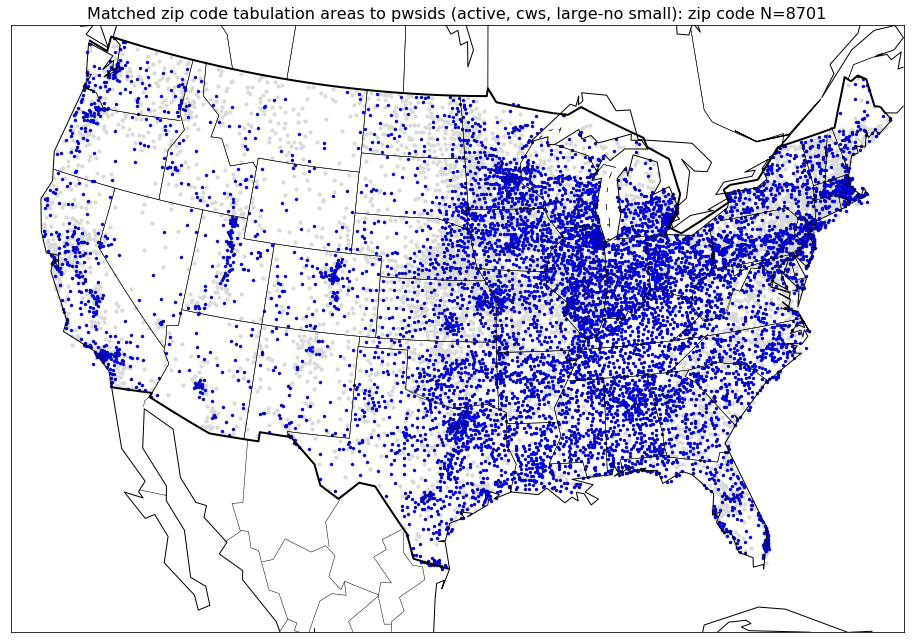

In [47]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_Lgx0, lat_Lgx0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_Lgx1, lat_Lgx1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy2_Lgx1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, large-no small): zip code N=%i' %t, fontsize = 16)
plt.show()

### At least one large (>=500) and one small (<500)

In [48]:
df_ACWS49_xy2_SmLgx0 = df_ACWS49_xy2[(df_ACWS49_xy2['small'] == 0) & (df_ACWS49_xy2['large'] == 0)] # none, actually
df_ACWS49_xy2_SmLgx1 = df_ACWS49_xy2[(df_ACWS49_xy2['small'] > 0) & (df_ACWS49_xy2['large'] > 0)]

# Extract the data for plotting
lat_SmLgx0 = df_ACWS49_xy2_SmLgx0['INTPTLAT'].values
lon_SmLgx0 = df_ACWS49_xy2_SmLgx0['INTPTLONG'].values

lat_SmLgx1 = df_ACWS49_xy2_SmLgx1['INTPTLAT'].values
lon_SmLgx1 = df_ACWS49_xy2_SmLgx1['INTPTLONG'].values


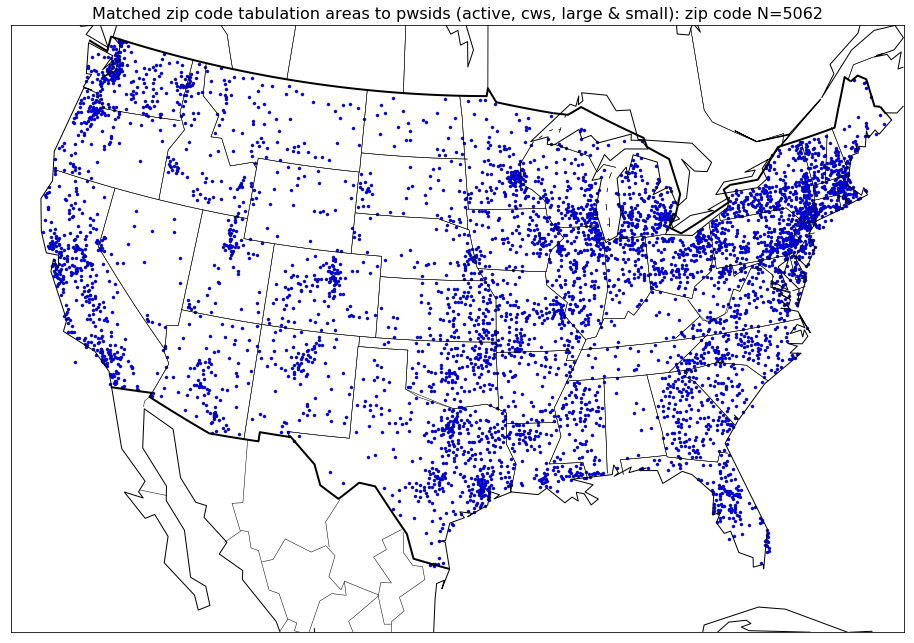

In [49]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_SmLgx0, lat_SmLgx0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_SmLgx1, lat_SmLgx1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy2_SmLgx1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, large & small): zip code N=%i' %t, fontsize = 16)
plt.show()

### By source type

*PRIMARY_SOURCE_CODE Description: The code showing the differentiation between the sources of water: ground water (GW),groundwater purchased (GWP), surface water (SW), surface water purchased (SWP), groundwater under influence of surface water (GU), or purchased ground water under influence of surface water source (GUP).* 

*could also use GW_SW_CODE Description: Indicates if the water system is considered having ground water (“gw”) or surface water (‘sw”) source under SDWA.* 

In [50]:
# some zip codes go across state lines, so keeping it reduced
df_ACWS49_p3 = pd.pivot_table(df_ACWS49, index=["ZIP_CODE_5"], columns=["PRIMARY_SOURCE_CODE"], 
                               aggfunc={"PRIMARY_SOURCE_CODE":len}, fill_value=0)
len(df_ACWS49_p3.index)

20784

In [51]:
df_ACWS49_p3.head()

PRIMARY_SOURCE_CODE                  
PRIMARY_SOURCE_CODE                  GU GUP GW GWP SW SWP
ZIP_CODE_5                                               
01001                                 0   0  1   0  0   1
01002                                 0   0  0   0  1   0
01005                                 0   0  2   0  0   0
01007                                 0   0  4   0  0   0
01008                                 0   0  0   0  1   0

In [52]:
df_ACWS49_p3f = pd.DataFrame(df_ACWS49_p3.to_records())
df_ACWS49_p3f.columns = [hdr.replace("('PRIMARY_SOURCE_CODE', ", "").replace(")", "").replace("'", "") \
                     for hdr in df_ACWS49_p3f.columns]

df_ACWS49_p3f.head()

ZIP_CODE_5  GU  GUP  GW  GWP  SW  SWP
0      01001   0    0   1    0   0    1
1      01002   0    0   0    0   1    0
2      01005   0    0   2    0   0    0
3      01007   0    0   4    0   0    0
4      01008   0    0   0    0   1    0

In [53]:
df_ACWS49_xy3 = pd.merge(df_ACWS49_p3f, ZipCoords, left_on='ZIP_CODE_5', right_on='GEOID', how='inner', validate="m:1")

print('unmatched =', len(df_ACWS49_p3f.index) - len(df_ACWS49_xy3.index))

unmatched = 1372


### GW

In [55]:
df_ACWS49_xy3_GWx0 = df_ACWS49_xy3[(df_ACWS49_xy3['GW'] == 0) & (df_ACWS49_xy3['GW'] == 0)]
df_ACWS49_xy3_GWx1 = df_ACWS49_xy3[(df_ACWS49_xy3['GW'] > 0) & (df_ACWS49_xy3['GW'] > 0)]

# Extract the data for plotting
lat_GWx0 = df_ACWS49_xy3_GWx0['INTPTLAT'].values
lon_GWx0 = df_ACWS49_xy3_GWx0['INTPTLONG'].values

lat_GWx1 = df_ACWS49_xy3_GWx1['INTPTLAT'].values
lon_GWx1 = df_ACWS49_xy3_GWx1['INTPTLONG'].values


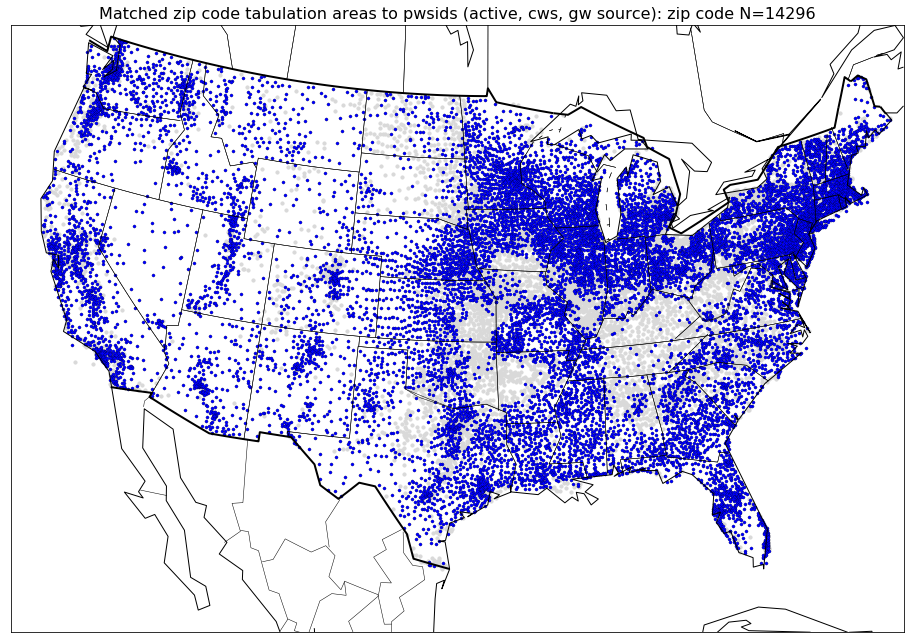

In [56]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_GWx0, lat_GWx0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_GWx1, lat_GWx1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy3_GWx1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, gw source): zip code N=%i' %t, fontsize = 16)
plt.show()

### SW

In [57]:
df_ACWS49_xy3_SWx0 = df_ACWS49_xy3[(df_ACWS49_xy3['SW'] == 0) & (df_ACWS49_xy3['SW'] == 0)]
df_ACWS49_xy3_SWx1 = df_ACWS49_xy3[(df_ACWS49_xy3['SW'] > 0) & (df_ACWS49_xy3['SW'] > 0)]

# Extract the data for plotting
lat_SWx0 = df_ACWS49_xy3_SWx0['INTPTLAT'].values
lon_SWx0 = df_ACWS49_xy3_SWx0['INTPTLONG'].values

lat_SWx1 = df_ACWS49_xy3_SWx1['INTPTLAT'].values
lon_SWx1 = df_ACWS49_xy3_SWx1['INTPTLONG'].values


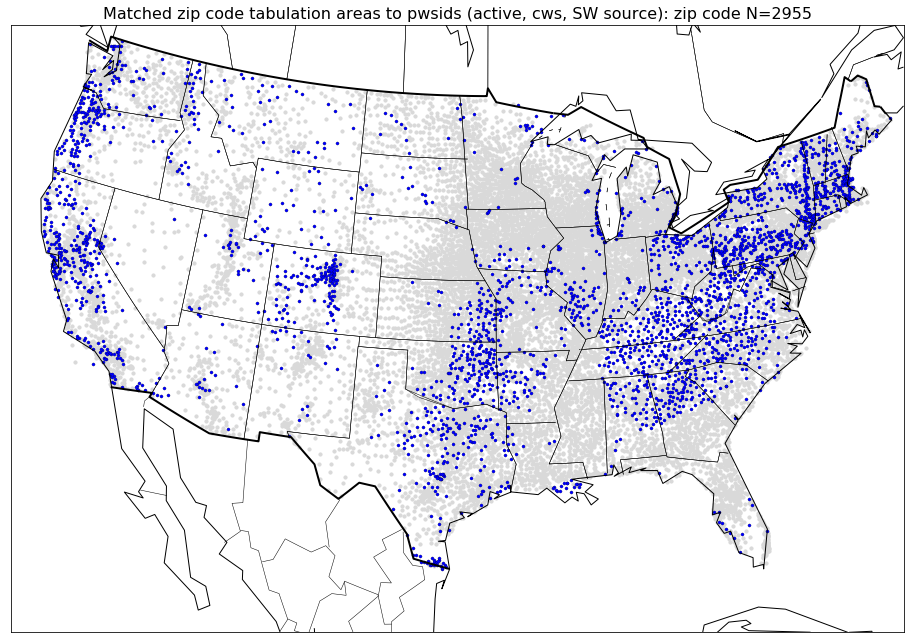

In [58]:
plt.figure(figsize=(16, 16))

m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates()

m.scatter(lon_SWx0, lat_SWx0, latlon=True, color="#d9d9d9", marker='o', s=10) #, alpha = 0.5

m.scatter(lon_SWx1, lat_SWx1, latlon=True, color="blue", marker='o', 
          edgecolor='black', s=10, lw = 0.2)

t = len(df_ACWS49_xy3_SWx1.index)

plt.title('Matched zip code tabulation areas to pwsids (active, cws, SW source): zip code N=%i' %t, fontsize = 16)
plt.show()